In [311]:
# Uncomment the line below with you python version
# if this is the first time you are running the notebook

#!pip install category_encoders
#!pip3 install category_encoders

In [312]:
#imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import category_encoders as ce

from six.moves import urllib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [313]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening"
CREDIT_DATA_URL = DOWNLOAD_ROOT + "/crx.data"
CREDIT_DATA_PATH = "datasets/credit-screening"

In [314]:
# fetch data from its origin
def fetch_credit_card_data(credit_data_url=CREDIT_DATA_URL, credit_path=CREDIT_DATA_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    credit_data_path = os.path.join(credit_path, "crx.data")
    urllib.request.urlretrieve(credit_data_url, credit_data_path)

fetch_credit_card_data()

In [315]:
# load data from csv file 
def load_credit_card_data(credit_data_path=CREDIT_DATA_PATH):
    csv_path=os.path.join(credit_data_path, "crx.data")
    pd.set_option('display.max_columns', None)
    col_names = ["Gender","Age","Debt","Married","BankCustomer","EducationLevel","Ethnicity","YearsEmployed","PriorDefault","Employed","CreditScore", "DriversLicense", "Citizen", "ZipCode", "Income" , "ApprovalStatus"]
    return pd.read_csv(csv_path, header=None, names=col_names)

dataset = load_credit_card_data()
dataframe = dataset.copy()


In [316]:
dataset = dataset.drop(['DriversLicense', 'ZipCode', 'BankCustomer', 'Gender'], axis=1)

# replace question mark with NaN
# replace + and - with 1 and 0
dataset = dataset.replace("?", np.nan).replace('+', 1).replace('-', 0)

# convert age from object to float
dataset = dataset.astype({"Age": float})
#replace missing numeric values with mean

dataset.fillna(dataset.mean(), inplace=True)
dataset.head(5)

# replace missing object values with the most freequent value
for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset = dataset.fillna(dataset[col].value_counts().index[0])

In [317]:
dataset['ApprovalStatus'].value_counts()

0    383
1    307
Name: ApprovalStatus, dtype: int64

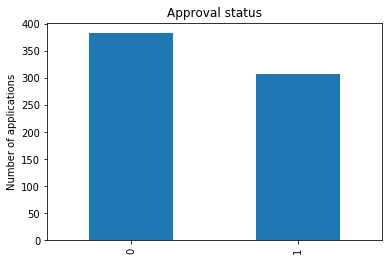

In [318]:
CountStatus = pd.value_counts(dataset['ApprovalStatus'].values, sort=False)
plt.ylabel('Number of applications')
plt.title('Approval status')
CountStatus.plot.bar()

In [319]:
dataset.dtypes

Age               float64
Debt              float64
Married            object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
Citizen            object
Income              int64
ApprovalStatus      int64
dtype: object

In [320]:
# Label encode for correlation
le = preprocessing.LabelEncoder()

labelEncodedSet = dataset.copy()
for col in dataset:
    if labelEncodedSet[col].dtypes == 'object':
        labelEncodedSet[col]=le.fit_transform(labelEncodedSet[col])

dataset.dtypes

Age               float64
Debt              float64
Married            object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
Citizen            object
Income              int64
ApprovalStatus      int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1349b20b8>,
      dtype=object)

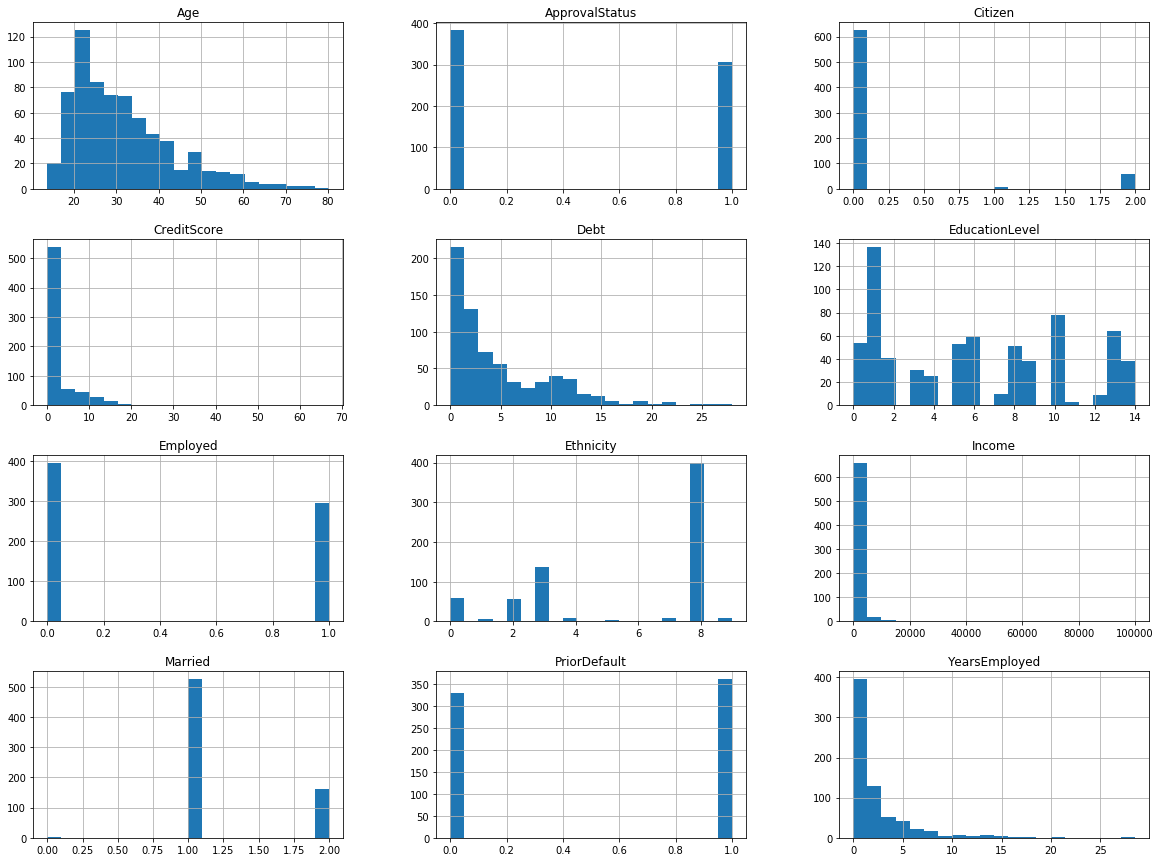

In [321]:
labelEncodedSet.hist(bins=20, figsize=(20, 15))

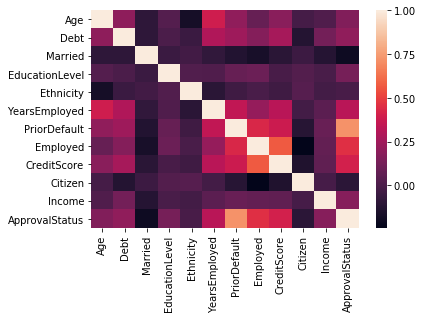

In [322]:
#Correlation heatmap
def make_corr_heatmap(data):
    corr = data.corr()
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

make_corr_heatmap(labelEncodedSet)

In [323]:
#Correlation with ApprovalStatus
labelEncodedSet.corr()['ApprovalStatus'].sort_values()

Married          -0.194306
Citizen          -0.100867
Ethnicity        -0.005249
EducationLevel    0.135625
Age               0.161627
Income            0.175657
Debt              0.206294
YearsEmployed     0.322475
CreditScore       0.406410
Employed          0.458301
PriorDefault      0.720407
ApprovalStatus    1.000000
Name: ApprovalStatus, dtype: float64

In [324]:
#use MAD to check the spread of the observation from the mean. MAD > std because we have outliers like age, income
labelEncodedSet.mad()

Age                  9.307123
Debt                 3.941786
Married              0.362222
EducationLevel       3.949422
Ethnicity            2.786221
YearsEmployed        2.223883
PriorDefault         0.498925
Employed             0.489498
CreditScore          3.088116
Citizen              0.320311
Income            1533.165402
ApprovalStatus       0.493934
dtype: float64

In [325]:
#drop columns with the lowest correlation, or columns that do not make sense
#dataset = dataset.drop(['DriversLicense', 'ZipCode', 'Ethnicity', 'Gender'], axis=1)
dataset.head()

,Age,Debt,Married,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,ApprovalStatus
0,30.83,0.000,u,w,v,1.25,t,t,1,g,0,1
1,58.67,4.460,u,q,h,3.04,t,t,6,g,560,1
2,24.50,0.500,u,q,h,1.50,t,f,0,g,824,1
3,27.83,1.540,u,w,v,3.75,t,t,5,g,3,1
4,20.17,5.625,u,w,v,1.71,t,f,0,s,0,1


In [326]:
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
dataset = ohe.fit_transform(dataset)
dataset.head()

,Age,Debt,Married_u,Married_y,Married_l,EducationLevel_w,EducationLevel_q,EducationLevel_m,EducationLevel_r,EducationLevel_cc,EducationLevel_k,EducationLevel_c,EducationLevel_d,EducationLevel_x,EducationLevel_i,EducationLevel_e,EducationLevel_aa,EducationLevel_ff,EducationLevel_j,EducationLevel_u,Ethnicity_v,Ethnicity_h,Ethnicity_bb,Ethnicity_ff,Ethnicity_j,Ethnicity_z,Ethnicity_u,Ethnicity_o,Ethnicity_dd,Ethnicity_n,YearsEmployed,PriorDefault_t,PriorDefault_f,Employed_t,Employed_f,CreditScore,Citizen_g,Citizen_s,Citizen_p,Income,ApprovalStatus
0,30.83,0.000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.25,1,0,1,0,1,1,0,0,0,1
1,58.67,4.460,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3.04,1,0,1,0,6,1,0,0,560,1
2,24.50,0.500,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.50,1,0,0,1,0,1,0,0,824,1
3,27.83,1.540,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.75,1,0,1,0,5,1,0,0,3,1
4,20.17,5.625,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.71,1,0,0,1,0,0,1,0,0,1


In [327]:
dataset.corr()['ApprovalStatus'].sort_values()

PriorDefault_f      -0.720407
Employed_f          -0.458301
Married_y           -0.188964
Ethnicity_ff        -0.183913
EducationLevel_ff   -0.181588
EducationLevel_i    -0.127762
Citizen_s           -0.109758
EducationLevel_k    -0.096879
EducationLevel_d    -0.090776
EducationLevel_aa   -0.054574
Ethnicity_v         -0.050350
EducationLevel_j    -0.035365
Ethnicity_dd        -0.021031
Ethnicity_j         -0.015240
Ethnicity_bb        -0.013044
EducationLevel_m    -0.011598
Ethnicity_u         -0.000112
EducationLevel_u    -0.000112
Ethnicity_o          0.005975
EducationLevel_c     0.007639
Ethnicity_n          0.008462
EducationLevel_r     0.029485
Citizen_p            0.039245
EducationLevel_e     0.044896
EducationLevel_w     0.045487
Married_l            0.060221
Ethnicity_z          0.066487
Citizen_g            0.089056
EducationLevel_cc    0.132708
EducationLevel_q     0.150082
Age                  0.161627
Income               0.175657
Married_u            0.180583
Ethnicity_

In [328]:
#separate the features and labels
dataset = dataset.values
X,y = dataset[:,0:34] , dataset[:,34]

In [329]:
#split the dataset into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [330]:
#rescale the training and testing sets
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)
rescaledX_val = scaler.fit_transform(X_val)

In [331]:
#instantiate the algorithms
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
gnb = GaussianNB()
logreg = LogisticRegression(solver='liblinear')

In [332]:
print("Random Forrest")

roc_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_rfc = cross_val_predict(rfc, rescaledX_train, y_train, cv=5)
cnf_matrix_rfc = metrics.confusion_matrix(y_train, y_pred_rfc)
tn_rfc, fp_rfc, fn_rfc, tp_rfc = cnf_matrix_rfc.ravel()

yi_rfc = 2*roc_rfc-1
sensitivity_rfc = tp_rfc/(tp_rfc + fn_rfc)
specificity_rfc = tn_rfc/(fp_rfc + tn_rfc)
yi_rfc_formula = sensitivity_rfc - (1 - specificity_rfc)

print("AUC: " , roc_rfc)
print("F1: " , f1_rfc)
print("Precission: " , precision_rfc)
print("Recall (Sensitivity): " , rec_rfc)
print("Accuracy: " , acc_rfc)
print("Sensitivity: " ,  sensitivity_rfc)
print("Specificity: " ,  specificity_rfc)
print("Youden's index", yi_rfc)
print("Youden's index formula", yi_rfc_formula)
print("True Negatives: ",tn_rfc)
print("False Positives: ",fp_rfc)
print("False Negatives: ",fn_rfc)
print("True Positives: ",tp_rfc)

Random Forrest
AUC:  1.0
F1:  1.0
Precission:  1.0
Recall (Sensitivity):  1.0
Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Youden's index 1.0
Youden's index formula 1.0
True Negatives:  175
False Positives:  0
False Negatives:  0
True Positives:  266


In [333]:
print("Naive Bayes")

roc_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_gnb= cross_val_score(gnb, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_gnb = cross_val_predict(gnb, rescaledX_train, y_train, cv=5)
cnf_matrix_gnb = metrics.confusion_matrix(y_train,y_pred_gnb)
tn_gnb, fp_gnb, fn_gnb, tp_gnb = cnf_matrix_gnb.ravel()

yi_gnb = 2*roc_gnb-1
sensitivity_gnb = tp_gnb/(tp_gnb+fn_gnb)
specificity_gnb = tn_gnb/(fp_gnb+tn_gnb)
yi_gnb_formula = sensitivity_gnb - (1 - specificity_gnb)

print("AUC" , roc_gnb)
print("F1: " , f1_gnb)
print("Precission: " , precision_gnb)
print("Recall (Sensitivity):" , rec_gnb)
print("Accuracy: " , acc_gnb)
print("Sensitivity: " ,  sensitivity_gnb)
print("Specificity: " ,  specificity_gnb)
print("Youden's index: ", yi_gnb)
print("Youden's index formula: ", yi_gnb_formula)
print("True Negatives: ",tn_gnb)
print("False Positives: ",fp_gnb)
print("False Negatives: ",fn_gnb)
print("True Positives: ",tp_gnb)

Naive Bayes
AUC 0.997088948787062
F1:  0.9962264150943396
Precission:  0.9962264150943396
Recall (Sensitivity): 0.9962264150943396
Accuracy:  0.9954545454545455
Sensitivity:  0.9962406015037594
Specificity:  0.9942857142857143
Youden's index:  0.994177897574124
Youden's index formula:  0.9905263157894737
True Negatives:  174
False Positives:  1
False Negatives:  1
True Positives:  265


In [334]:
print("Logistic regression")

roc_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_val_logreg = cross_val_predict(logreg, rescaledX_train, y_train, cv=5)
# Compute confusion matrix
cnf_matrix_logreg = metrics.confusion_matrix(y_train, y_pred_val_logreg)
tn_logreg, fp_logreg, fn_logreg, tp_logreg = cnf_matrix_logreg.ravel()

yi_logreg = 2*roc_logreg-1
sensitivity_logreg = tp_logreg/(tp_logreg+fn_logreg)
specificity_logreg = tn_logreg/(fp_logreg+tn_logreg)
yi_logreg_formula = sensitivity_logreg - (1 - specificity_logreg)

print("AUC of Logistic Regression is: " , roc_logreg)
print("F1: " , f1_logreg)
print("Precision: " , precision_logreg)
print("Recall (Sensitivity): " , rec_logreg)
print("Accuracy: " , acc_logreg)
print("Sensitivity: " ,  sensitivity_logreg)
print("Specificity: " ,  specificity_logreg)
print("Youden's index", yi_logreg)
print("Youden's index formula", yi_logreg_formula)
print("True Negatives: ",tn_logreg)
print("False Positives: ",fp_logreg)
print("False Negatives: ",fn_logreg)
print("True Positives: ",tp_logreg)


Logistic regression
AUC of Logistic Regression is:  1.0
F1:  1.0
Precision:  1.0
Recall (Sensitivity):  1.0
Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Youden's index 1.0
Youden's index formula 1.0
True Negatives:  175
False Positives:  0
False Negatives:  0
True Positives:  266


In [335]:
import itertools    

# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Random forest
Confusion matrix, without normalization
[[175   0]
 [  0 266]]


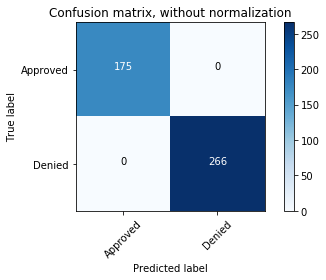

In [336]:
print("Random forest")
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rfc, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')

Naive Bayes
Confusion matrix, without normalization
[[174   1]
 [  1 265]]


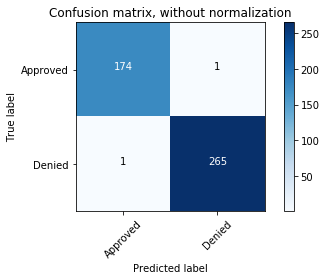

In [337]:
print("Naive Bayes")
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_gnb, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')

Logistic regression
Confusion matrix, without normalization
[[175   0]
 [  0 266]]


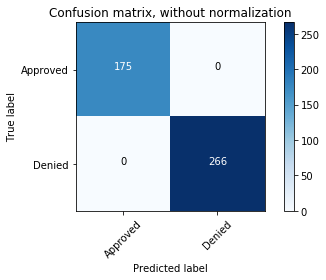

In [338]:
print("Logistic regression")
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_logreg, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')

In [339]:
param_grid = {
    'max_depth': np.linspace(1, 32, 32, endpoint=True),
    'max_features': list(range(1,rescaledX_train.shape[1])),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200]
}
#grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          #cv = 5, n_jobs = -1, verbose = 2)
#grid_search.fit(rescaledX_val, y_val)

#rgs = RandomizedSearchCV(estimator=rfc, param_distributions  = param_grid, n_iter = 5000, cv = 10, n_jobs = -1, verbose = 2)
#rgs.fit(rescaledX_val, y_val)

#rgs.best_params_

In [340]:
#instantiate rfc with the best parameters
#rfc_best_model = RandomForestClassifier(max_depth=26.0,max_features=3,min_samples_leaf=0.1,min_samples_split= 0.3,n_estimators=8,random_state=42)
rfc_best_model = RandomForestClassifier(max_depth=20.0,max_features=3,min_samples_leaf=0.1,min_samples_split= 0.3,n_estimators=10,random_state=42)
#fit the train data
rfc_best_model.fit(rescaledX_train, y_train)
#predict on validation set
y_pred_val = rfc_best_model.predict(rescaledX_val)

In [341]:
#print the metrics for validation set
print("AUC: " ,  metrics.roc_auc_score(y_val,y_pred_val))
print("F1: " , metrics.f1_score(y_val,y_pred_val))
print("Precission: " , metrics.precision_score(y_val,y_pred_val))
print("Recall: " ,  metrics.recall_score(y_val,y_pred_val))
print("Accuracy: " ,  metrics.accuracy_score(y_val,y_pred_val))
print("Youden's index", (2*metrics.roc_auc_score(y_val,y_pred_val)-1))
cnf_matrix = metrics.confusion_matrix(y_val,y_pred_val)
tn, fp, fn, tp = cnf_matrix.ravel()

yi_rfc = ((tp/(tp+fn)-(1-(tn/(fp+tn)))))

print("Youden's formula", yi_rfc)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
      

AUC:  0.6296296296296297
F1:  0.7402597402597402
Precission:  0.5876288659793815
Recall:  1.0
Accuracy:  0.6396396396396397
Youden's index 0.2592592592592593
Youden's formula 0.2592592592592593
True Negatives:  14
False Positives:  40
False Negatives:  0
True Positives:  57


Confusion matrix, without normalization
[[14 40]
 [ 0 57]]


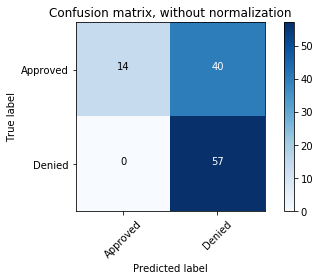

In [342]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')

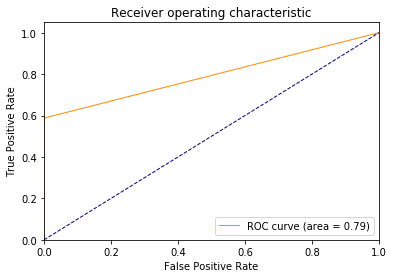

In [343]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_pred_val, y_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [344]:
#instantiate rfc with the best parameters
rfc_best_model = RandomForestClassifier(max_depth=20.0,max_features=3,min_samples_leaf=0.1,min_samples_split= 0.3,n_estimators=10,random_state=42)

#fit the train data
rfc_best_model.fit(rescaledX_train, y_train)
#predict on test set
y_pred_val = rfc_best_model.predict(rescaledX_test)

In [345]:
#print the metrics for test set
print("AUC: " ,  metrics.roc_auc_score(y_test,y_pred_val))
print("F1: " , metrics.f1_score(y_test,y_pred_val))
print("Precission: " , metrics.precision_score(y_test,y_pred_val))
print("Recall: " ,  metrics.recall_score(y_test,y_pred_val))
print("Accuracy: " ,  metrics.accuracy_score(y_test,y_pred_val))
print("Youden's index", (2*metrics.roc_auc_score(y_test,y_pred_val)-1))
cnf_matrix = confusion_matrix(y_test,y_pred_val)
tn, fp, fn, tp = cnf_matrix.ravel()

yi_rfc = ((tp/(tp+fn)-(1-(tn/(fp+tn)))))

print("Youden's formula", yi_rfc)
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)
      

AUC:  0.5833333333333333
F1:  0.7236180904522613
Precission:  0.5669291338582677
Recall:  1.0
Accuracy:  0.6014492753623188
Youden's index 0.16666666666666652


NameError: name 'confusion_matrix' is not defined

In [ ]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Approved','Denied'],
                      title='Confusion matrix, without normalization')